In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from itertools import combinations
import os
from venn import venn
%matplotlib inline

In [2]:
# Set output folder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [4]:
HeLa_DMEM_comp_hits_df = pd.read_csv('../2_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv')
HeLa_DMEM_WC_hits_df = pd.read_csv('../2_HeLa_Screens_Summary/outputs/HeLa_DMEM_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv')
HeLa_DMEM_hits_df = pd.concat([HeLa_DMEM_comp_hits_df,HeLa_DMEM_WC_hits_df]).rename(columns={'Sum':'Whole'})
HeLa_HPLM_comp_hits_df = pd.read_csv('../2_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv')
HeLa_HPLM_WC_hits_df = pd.read_csv('../2_HeLa_Screens_Summary/outputs/HeLa_HPLM_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv')
HeLa_HPLM_hits_df = pd.concat([HeLa_HPLM_comp_hits_df,HeLa_HPLM_WC_hits_df]).rename(columns={'Sum':'Whole'})
A549_comp_hits_df = pd.read_csv('../4_A549_Screen_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_1_fdr_compartment_specific_hits.csv')
A549_WC_hits_df = pd.read_csv('../4_A549_Screen_Summary/outputs/A549_plate_level_median_per_feat_sig_genes_1_fdr_whole_cell_hits.csv')
A549_hits_df = pd.concat([A549_comp_hits_df,A549_WC_hits_df]).rename(columns={'Sum':'Whole'})

In [6]:
# See Fig 2A/B for threshold calculation
thresh_dict_HeLa_DMEM = {'Mito':64, 
               'ConA':52,
               'WGA':72,
               'DAPI':60,
               'Phalloidin':61,
               'Whole':221}
# See Fig 2A/B for threshold calculation
thresh_dict_HeLa_HPLM = {'Mito':101, 
               'ConA':72,
               'WGA':117,
               'DAPI':82,
               'Phalloidin':74,
               'Whole':347}
# See Fig 4A/B for threshold calculation
thresh_dict_A549 = {'Mito':49, 
               'ConA':37,
               'WGA':57,
               'DAPI':78,
               'Phalloidin':48,
               'Whole':217}

In [7]:
profile_list = ['Mito', 'ConA', 'WGA', 'DAPI', 'Phalloidin', 'Whole']

def make_channel_df(thresh_dict, df, numchans,name):
    channel_df = pd.DataFrame(columns=profile_list + ['Number', 'NumChanns'])

    for num in range(1,numchans+1):
        combo_list = list(combinations(profile_list, num))
        for item in combo_list:
            entry = {}
            entry['NumChanns'] = num
            entry['Channels_Whole_List'] = list(item)
            #entry['Channels_Whole_Name']
            for n in range(len(item)):
                entry[item[n]] = item[n]
            df_slice = df.copy()
            for profile in profile_list:
                if profile in item:
                    df_slice = df_slice.loc[(df_slice[profile] >= thresh_dict[profile])]
                else:
                    df_slice = df_slice.loc[(df_slice[profile] < thresh_dict[profile])]
            entry['Number'] = len(df_slice)
            channel_df = pd.concat([channel_df,pd.DataFrame([entry])])

    Total_Hits = sum(channel_df['Number'])
    print (f'All hits counted for {name}: {Total_Hits == len(df)}')
    return channel_df

def channel_df_for_vis(channel_df):
    channel_df = channel_df.fillna(' ')

    sortlist = ['NumChanns','Whole','DAPI','Phalloidin','ConA','Mito','WGA',]
    nonzero_df = channel_df.loc[channel_df['Number']!=0].sort_values(by=sortlist)
    nonzero_df['Channels_Whole_Name']= [' '.join(x) for x in nonzero_df['Channels_Whole_List']]

    cell_text = cell_colors = nonzero_df[['Whole','DAPI','Phalloidin','ConA','Mito','WGA',]].values.tolist()
    cell_text = [[x.replace('Mito','M') for x in l] for l in cell_text]
    cell_text = [[x.replace('ConA','C') for x in l] for l in cell_text]
    cell_text = [[x.replace('DAPI','D') for x in l] for l in cell_text]
    cell_text = [[x.replace('Phalloidin','P') for x in l] for l in cell_text]
    cell_text = [[x.replace('WGA','W') for x in l] for l in cell_text]
    cell_text = [[x.replace('Whole','T') for x in l] for l in cell_text]

    cell_colors = [[x.replace('Mito','gold') for x in l] for l in cell_colors]
    cell_colors = [[x.replace('ConA','orange') for x in l] for l in cell_colors]
    cell_colors = [[x.replace('DAPI','royalblue') for x in l] for l in cell_colors]
    cell_colors = [[x.replace('Phalloidin','limegreen') for x in l] for l in cell_colors]
    cell_colors = [[x.replace('WGA','orangered') for x in l] for l in cell_colors]
    cell_colors = [[x.replace('Whole','gainsboro') for x in l] for l in cell_colors]
    cell_colors = [[x.replace(' ','white') for x in l] for l in cell_colors]

    cell_text = list(map(list, zip(*cell_text)))
    cell_colors = list(map(list, zip(*cell_colors)))

    return nonzero_df, cell_text, cell_colors

def vis_channel_df(nonzero_df, cell_text, cell_colors,name):
    # Colorized graph
    plt.figure(figsize=(15,4))
    ax = sns.barplot(
        data=nonzero_df, 
        x="Channels_Whole_Name", y="Number", errorbar=None,
        color='white', linewidth=1, edgecolor=".2"
    )
    the_table = plt.table(cellText=cell_text,
                        cellColours=cell_colors,
                        loc='bottom')
    # Adjust layout to make room for the table:
    plt.subplots_adjust(bottom=-0.15)

    plt.ylabel("Number of Genes")
    plt.xlabel("")
    plt.xticks([])
    plt.title(f'{name} \nNumber of Genes Significant in Combinations of Profiles')

    ax.text(.99, .8, ' Whole Profile = T \n DAPI = D \n Phalloidin = P \n ConA = C \n Mito = M \n WGA = W', transform=ax.transAxes,
            bbox={'facecolor': 'white','pad': 5},ha='right', va='center',)

    plt.savefig(os.path.join(output_folder,'figure_panels',f'{name}_Significant_Genes_by_Profile_Combo.png'), dpi=300,bbox_inches='tight')
    plt.show()

All hits counted for HeLa_DMEM: True


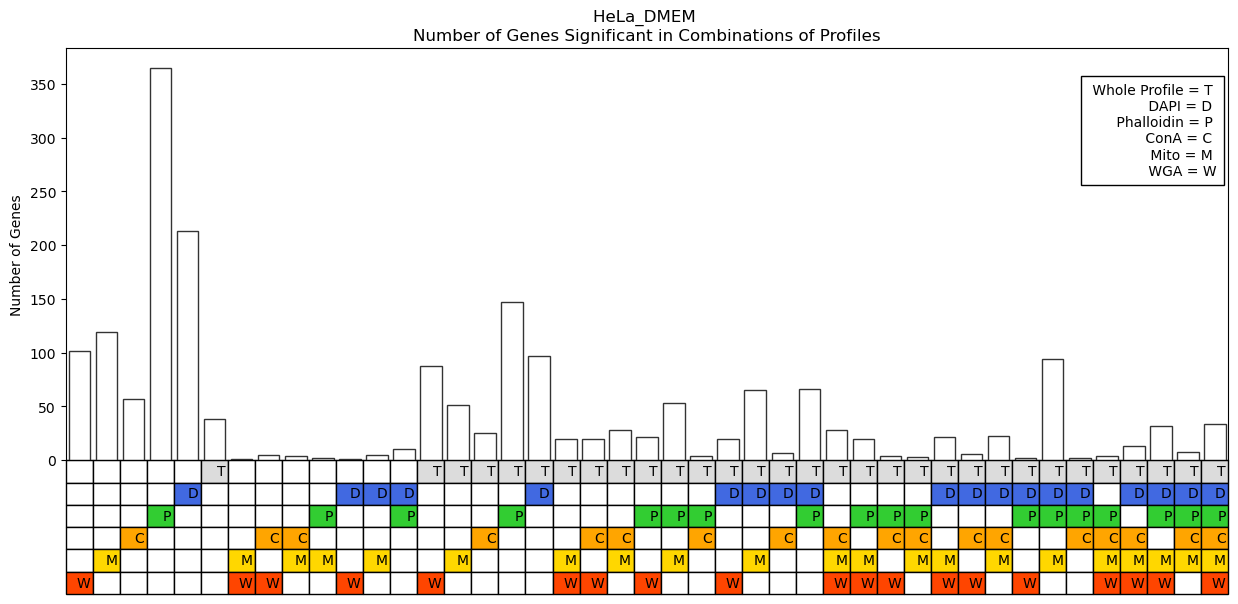

In [8]:
channel_df = make_channel_df(thresh_dict_HeLa_DMEM, HeLa_DMEM_hits_df, 6,'HeLa_DMEM')
nonzero_df, cell_text, cell_colors = channel_df_for_vis(channel_df)
vis_channel_df(nonzero_df, cell_text, cell_colors,'HeLa_DMEM')

All hits counted for HeLa_HPLM: True


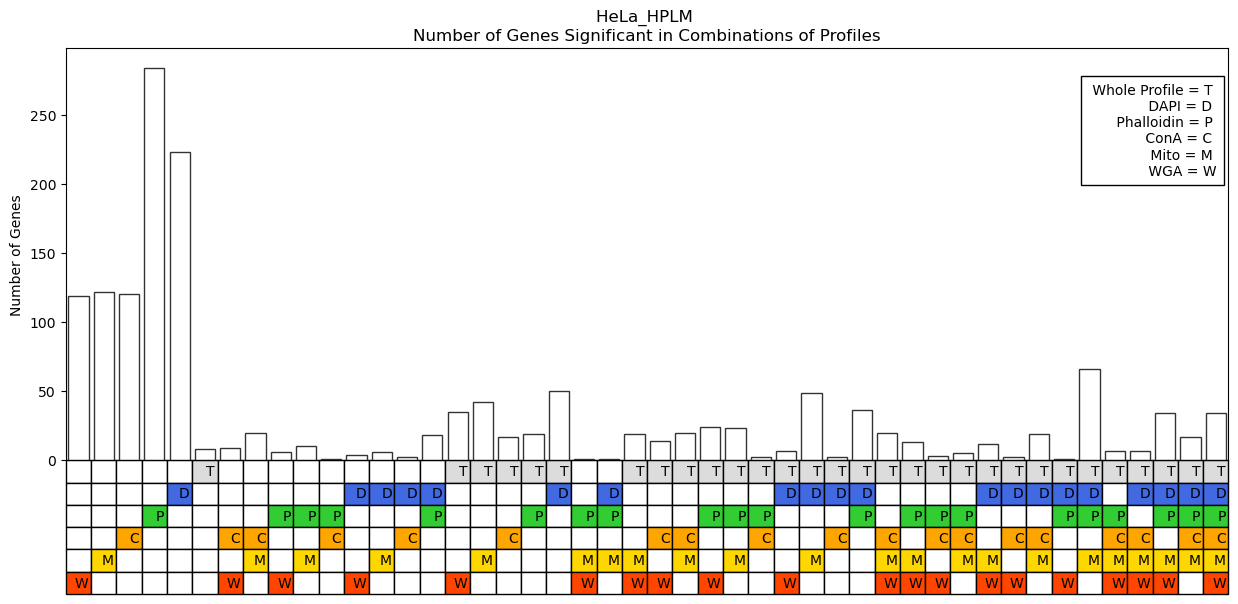

In [9]:
channel_df = make_channel_df(thresh_dict_HeLa_HPLM, HeLa_HPLM_hits_df, 6,'HeLa_HPLM')
nonzero_df, cell_text, cell_colors = channel_df_for_vis(channel_df)
vis_channel_df(nonzero_df, cell_text, cell_colors,'HeLa_HPLM')

All hits counted for A549: True


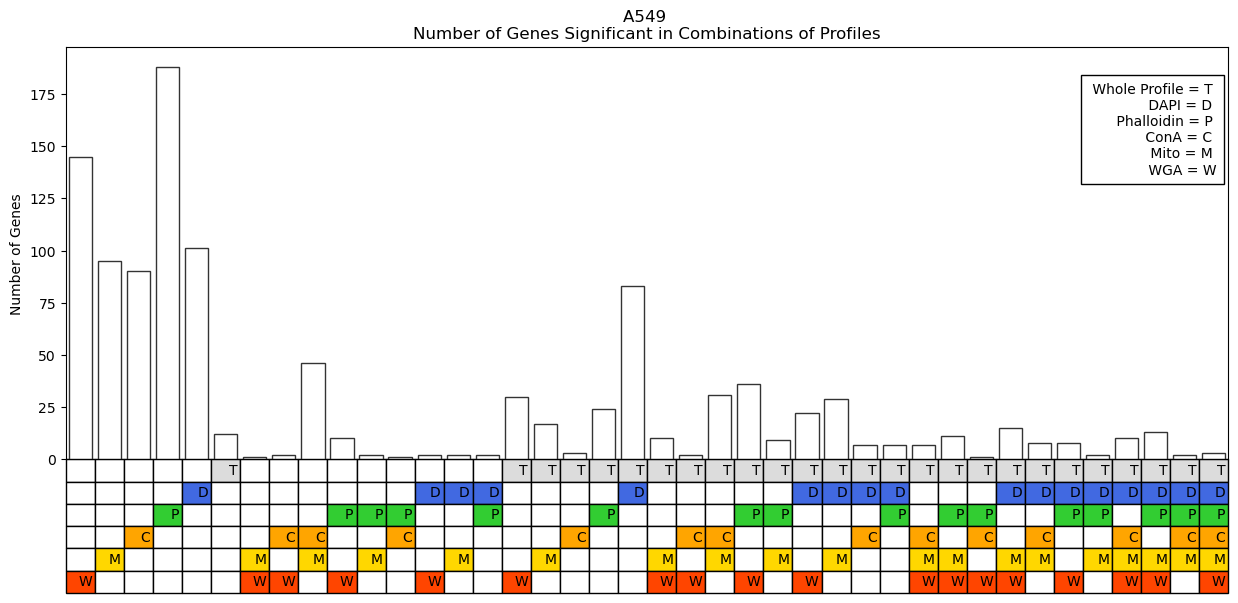

In [10]:
channel_df = make_channel_df(thresh_dict_A549, A549_hits_df, 6,'A549')
nonzero_df, cell_text, cell_colors = channel_df_for_vis(channel_df)
vis_channel_df(nonzero_df, cell_text, cell_colors,'A549')

## Venn Diagrams

In [11]:
channel_list = ['Mito', 'ConA', 'WGA', 'DAPI', 'Phalloidin']
def make_venn(df,thresh_dict,name):
    venn_dict = {}
    for channel in channel_list:
        venn_dict[channel] = set(df.loc[df[channel]>=thresh_dict[channel],'Gene'])
    cmap = ['gold','coral','crimson','blue','limegreen']
    venn(venn_dict, cmap=cmap)
    plt.title(f'{name} \nNumber of Genes Significant in Combinations of Profiles')
    plt.savefig(os.path.join(output_folder,'figure_panels',f'{name}_Channel_Venn.png'), dpi=300,bbox_inches='tight')

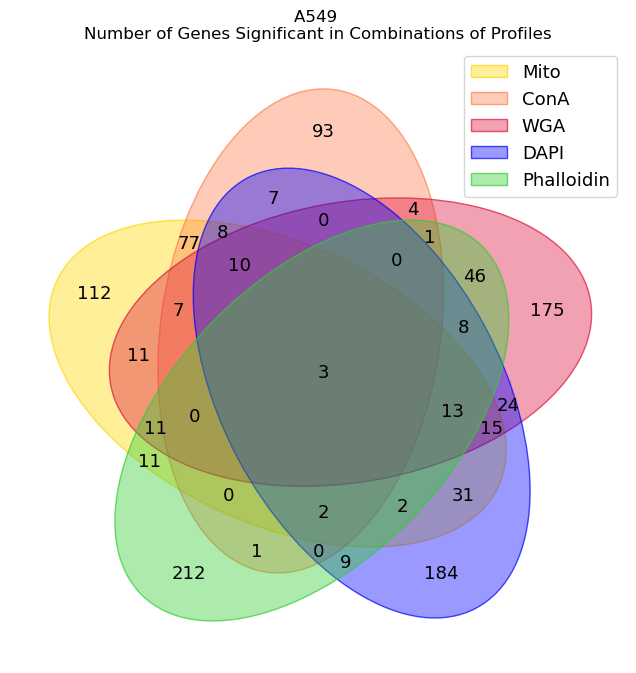

In [12]:
make_venn(A549_hits_df, thresh_dict_A549,'A549')

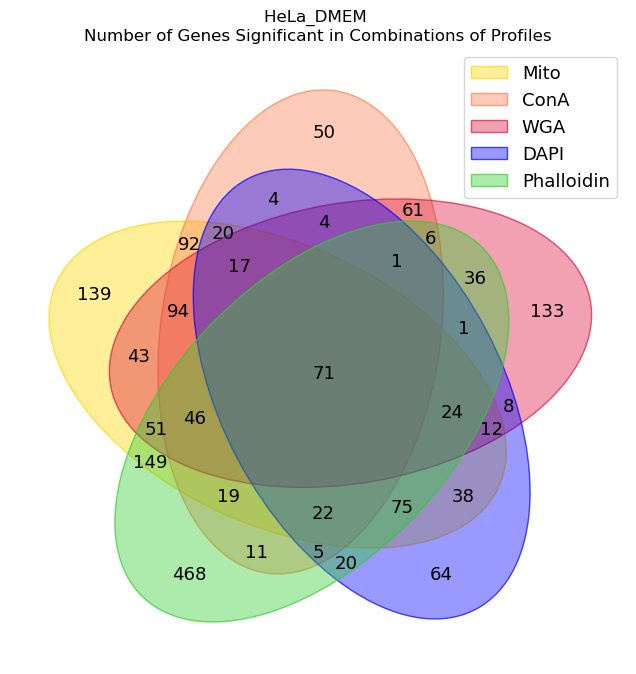

In [13]:
make_venn(HeLa_DMEM_hits_df, thresh_dict_A549,'HeLa_DMEM')

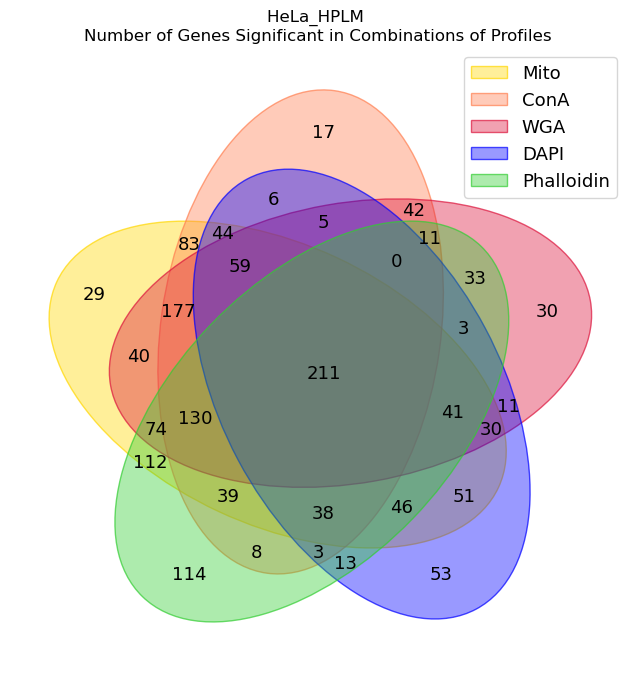

In [14]:
make_venn(HeLa_HPLM_hits_df, thresh_dict_A549,'HeLa_HPLM')